In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import numpy as np
%matplotlib inline

In [2]:
import re  #regular expression

In [3]:
sentences = """Throughout my career, I have had the opportunity to work on a diverse range of mobile app projects. My proficiency in Flutter, along with my Android development skills, has allowed me to create user-friendly and high-performance applications. I take pride in my ability to transform creative concepts into functional, feature-rich apps that deliver exceptional user experiences."""

Clean Data

In [4]:
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences) #replace space with non alphanumeric character

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip() #strip() method removes any leading/trailing spaces resulting from this operation.

# lower all characters
sentences = sentences.lower()

Vocabulary

In [5]:
words = sentences.split()
vocab = set(words)

In [6]:
vocab

{'ability',
 'allowed',
 'along',
 'and',
 'android',
 'app',
 'applications',
 'apps',
 'career',
 'concepts',
 'create',
 'creative',
 'deliver',
 'development',
 'diverse',
 'exceptional',
 'experiences',
 'feature',
 'flutter',
 'friendly',
 'functional',
 'had',
 'has',
 'have',
 'high',
 'in',
 'into',
 'me',
 'mobile',
 'my',
 'of',
 'on',
 'opportunity',
 'performance',
 'pride',
 'proficiency',
 'projects',
 'range',
 'rich',
 'skills',
 'take',
 'that',
 'the',
 'throughout',
 'to',
 'transform',
 'user',
 'with',
 'work'}

In [12]:
vocab_size = len(vocab)
embed_dim = 10 # indicates the dimensionality of the word embeddings.
context_size = 2  #Refers to the size of the window or context around each word during training
#predicts the current word based on its surrounding context words within a specified window size
#This parameter sets how many words before and after the target word are considered as context.

Implementation

In [13]:
# dictionaries are used to map words to indices and indices back to words,
#enumerate function generates pairs of indices and words from the vocab list
#dictionary comprehension that iterates &assigning each word as a key and its index as the value.
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

Data bags

In [14]:
# data - [(context), target]
#This loop iterates over the words in the words list, excluding the first two and the last two words
data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]] #creates a context window consisting of two words before and two words after the target word.
    target = words[i]#line extracts the target word itself.
    data.append((context, target))
print(data[:5])

[(['throughout', 'my', 'have', 'had'], 'career'), (['my', 'career', 'had', 'the'], 'have'), (['career', 'have', 'the', 'opportunity'], 'had'), (['have', 'had', 'opportunity', 'to'], 'the'), (['had', 'the', 'to', 'work'], 'opportunity')]


Embeddings

In [15]:
# refers to the process of representing words or phrases as numerical vectors in a continuous space
embeddings =  np.random.random_sample((vocab_size, embed_dim))

Linear Model

In [ ]:
#linear regression type
def linear(m, theta):#m-input data,theta-weights
    w = theta
    return m.dot(w) #dot product of inputand weights

Log softmax + NLLloss = Cross Entropy

In [ ]:
#for classification task used

#: Normalizes the exponential values by dividing each element by the sum of all exponential values. This operation computes the softmax function, 
#the input array into a probability distribution.
def log_softmax(x):
    e_x = np.exp(x - np.max(x)) #step helps prevent potential numerical overflow by subtracting the maximum value before computing exponentials.
    return np.log(e_x / e_x.sum()) 

In [ ]:
#negative log-likelihood loss  -measures how well the model's predicted probabilities align with the actual target classes. 
#logs- log scores for each class
#targets-indices of the target classes.
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets] # Extracts the log probabilities for the target classes using advanced indexing
    return -out.sum()/len(out)#Calculates the negative log-likelihood loss.

In [ ]:
#computes  gradient of the cross-entropy loss with respect to the logits
#logits-outputs from a neural network before applying softmax function
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)# Initializes an array of zeros with the same shape as the logits.
    out[np.arange(len(logits)),target] = 1 #set to 1 by apply one hot encoding

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True) #step computes the probabilities for each class.

    return (- out + softmax) / logits.shape[0] #Computes the gradient of the cross-entropy loss with respect to the logits.

Forward function

In [ ]:
# performs the forward pass of a neural network or a model
#context_idxs: Represents the indices of the context words 
#theta: Denotes the weights used in the linear transformation.

def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)# Retrieves the embeddings corresponding to the indices of context words from the embeddings matrixand reshpe to 1d array
    n = linear(m, theta)#step computes the linear transformation of the input embeddings.
    o = log_softmax(n)

    return m, n, o
#m: The extracted embeddings for the context words.
#n: The result of the linear transformation.
#o: The log-softmax probabilities.

Backward function

In [ ]:
#computes the gradient of the loss with respect to the weights (theta) using backpropagation
#preds: Represents the predictions obtained from the forward pass
def backward(preds, theta, target_idxs):
    m, n, o = preds

    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)#: Computes the gradient of the log-softmax loss function with respect to the linear transformation output n.
    dw = m.T.dot(dlog)

    return dw # Returns the computed gradient of the weights.

#This step calculates the gradient of the loss function.

Optimize function

In [ ]:
# simple gradient descent update to optimize the weights
#grad: Denotes the gradient of the weights
#lr=0.03: Specifies the learning rate, which controls the size of the step taken during gradient descent. 
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr # adjusts the weights in the direction that minimizes the loss function
    return theta

Training

In [ ]:
# initializes the theta matrix with random values within the range of -1 to 1.
#(2 * context_size * embed_dim, vocab_size): Defines the shape of the resulting matrix. 
#It creates a matrix with dimensions 2 * context_size * embed_dim (rows) by vocab_size (columns).
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

In [ ]:
epoch_losses = {}

for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])#Converts the context words into their corresponding indices using the word_to_ix dictionary
        preds = forward(context_idxs, theta)#function to obtain predictions for the given context.

        target_idxs = np.array([word_to_ix[target]])#Converts the target word into its index using the word_to_ix dictionary.
        loss = NLLLoss(preds[-1], target_idxs)#Computes the negative log-likelihood loss for the predicted probabilities and the target index using the NLLLoss function.

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)# Computes the gradient using backpropagation with the backward function
        theta = optimize(theta, grad, lr=0.03)# Updates the weights (theta) using gradient descent with the optimize function


    epoch_losses[epoch] = losses
    #Stores the losses obtained during each epoch in a dictionary (epoch_losses) with the epoch number as the key.
    


Analyze

Plot loss/epoch

Text(0, 0.5, 'Losses')

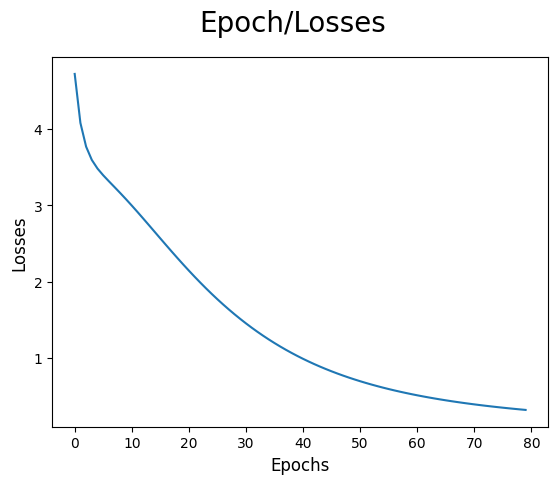

In [ ]:
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

Predict function

In [ ]:
def predict(words):#words, which represents a sequence of words.
    context_idxs = np.array([word_to_ix[w] for w in words])#Converts the input sequence of words into their corresponding indices using the word_to_ix dictionary.
    preds = forward(context_idxs, theta)#obtain predictions for the next word in the sequence, given the context represented by the indices.
    word = ix_to_word[np.argmax(preds[-1])]
    #: Retrieves the word associated with the index having the highest probability among the predictions obtained from the model

    return word

In [ ]:

predict(['transform','creative','into','functional' ])

'concepts'

Accuracy

In [ ]:
def accuracy():
    wrong = 0

    for context, target in data:# Iterates through the dataset.
        if(predict(context) != target):#.Compares the predicted word with the actual target word.
            wrong += 1 #If the predicted word does not match the target word, increments the wrong counter by 1.

    return (1 - (wrong / len(data)))#Computes the accuracy by subtracting the ratio of incorrect predictions (wrong) to the total number of data points (len(data)) from 1
 



In [ ]:
accuracy()

1.0